In [ ]:
#@title Mount Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
#@title Install Kaggle

! pip install -q kaggle

! pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 4.7MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=d55c389065ee3c25aebc3d92c018fee3592a5a9391496c5c00f2a3873860be89
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
#@title Download

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c histopathologic-cancer-detection

100% 6.29G/6.31G [01:11<00:00, 95.1MB/s]
100% 6.31G/6.31G [01:11<00:00, 95.3MB/s]


In [3]:
#@title Unzip
# Unzip and load the dataset onto your current directory

import zipfile

zip = zipfile.ZipFile('histopathologic-cancer-detection.zip')

zip.extractall()

# Brief description of the problem and data 

## Goal
The goal of this project is to use ML techniques, specifically CNNs, to identify metastatic cancer in small image patches taken from larger digital pathology scans. The image data had labels 1 and 0, cancer or no cancer. A dataset of unlabeled images is provided to test the model. 

## What is this cancer and why is it important to detect?
Cancer is a massive killer, claiming close to 2 million lives in 2020.
The National Cancer Institute defines histopathology as "the study of diseased cells and tissues using a microscope."Histology is the study of tissues, and pathology is the study of disease. So taken together, histopathology literally means the study of tissues as relates to disease. (Source: Verywell Health) 
A tool that can quickly identify cancer cells can help doctors diagnose and treat cancer faster. 


In [76]:
# a complete ML pipeline submission copy and paste

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


#size of images?, 96x96 but we are interested in the center 32 x 32 


# Exploratory Data Analysis 



## How many images in train and test set?

In [86]:
#https://stackoverflow.com/questions/2632205/how-to-count-the-number-of-files-in-a-directory-using-python
path, dirs, files = next(os.walk("../content/test/"))
file_count = len(files)
print(file_count)

57458


In [87]:
path, dirs, files = next(os.walk("../content/train/"))
file_count = len(files)
print(file_count)

220025


## What is cancer non cancer split of train set?


In [5]:
#https://towardsdatascience.com/upgrade-your-image-classifier-with-balanced-data-ddea93859c0f
df_data = pd.read_csv('../content/train_labels.csv')

# Check the class distribution

print(df_data['label'].value_counts())

0    130908
1     89117
Name: label, dtype: int64


##Size and dimension of images?

In [89]:
img = cv2.imread("../content/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif")
img.shape

(96, 96, 3)

## Image Visualization, Cancer vs Not

Text(0, 0.5, 'Negative samples')

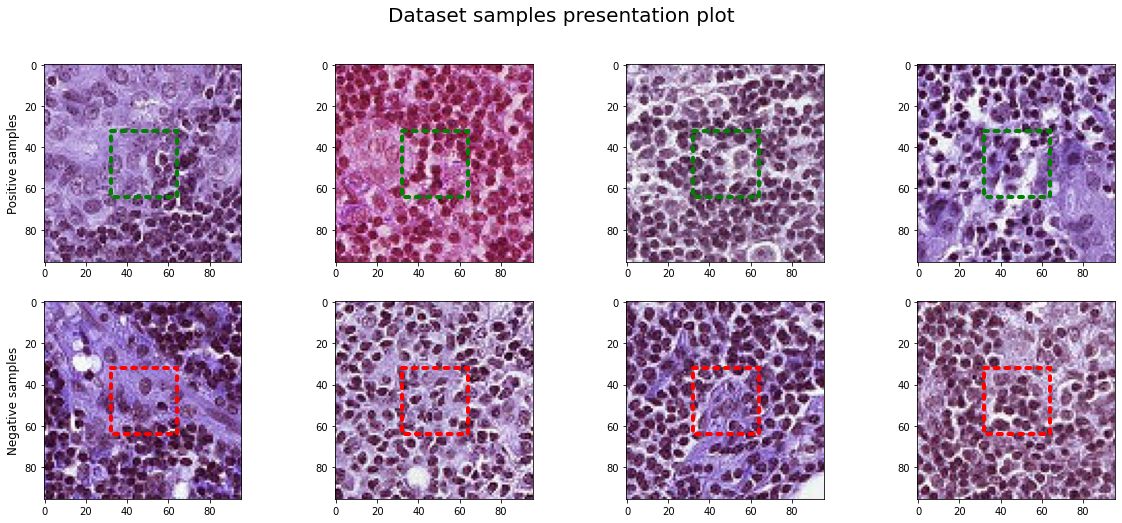

In [77]:
#https://www.kaggle.com/syedaar/histopathologic-cancer-detection-using-tensorflow
train_dirname = "../content/train/"
positive_samples = df_data.loc[df_data['label'] == 1].sample(4)
negative_samples = df_data.loc[df_data['label'] == 0].sample(4)
positive_images = []
negative_images = []
for sample in list(positive_samples.index):
    path = os.path.join(train_dirname, sample+'.tif')
    img = cv2.imread(path)
    positive_images.append(img)
        
for sample in list(negative_samples.index):
    path = os.path.join(train_dirname, sample+'.tif')
    img = cv2.imread(path)
    negative_images.append(img)

fig,axis = plt.subplots(2,4,figsize=(20,8))
fig.suptitle('Dataset samples presentation plot',fontsize=20)
for i,img in enumerate(positive_images):
    axis[0,i].imshow(img)
    rect = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='g',facecolor='none', linestyle=':', capstyle='round')
    axis[0,i].add_patch(rect)
axis[0,0].set_ylabel('Positive samples', size='large')
for i,img in enumerate(negative_images):
    axis[1,i].imshow(img)
    rect = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    axis[1,i].add_patch(rect)
axis[1,0].set_ylabel('Negative samples', size='large')
    


In [6]:

SAMPLE_SIZE = 80000 
# the number of images we use from each of the two classes, allows balance


# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)


# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)


# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)


# shuffle
df_data = df_data.sample(frac=1)

In [ ]:
#histogram
#balance training set so we have equal cancer and no cancer images. This means the model will not be better at one or the other. OR choose to use more data. 
#sample size from towards datascience 
#data preparation guide https://towardsdatascience.com/data-preparation-guide-for-detecting-histopathologic-cancer-detection-7b96d6a12004
#image class from scratch https://keras.io/examples/vision/image_classification_from_scratch/#build-a-model


In [7]:
training_sample_percentage = 0.9
training_sample_size = int(len(df_data)*training_sample_percentage)
validation_sample_size = len(df_data)-training_sample_size

train_df = df_data.sample(n=training_sample_size)
val_df = df_data[~df_data.index.isin(train_df.index)]

In [8]:
val_df.head(3)

,id,label
138440,864f5b22b4d7b208073474b1dac32e9f026c72ee,1
48692,d8a2aaf11f89aea19a9f26c47b8a763e25718587,0
155877,67673dbcb23aef244a29642987f6ac33b46c584b,1


In [9]:
train_df.head(3)

,id,label
10782,f88ddbc88b19602d2a68b0a1f472e537822206d5,0
102010,b675422b5d625786285ab769488cb024f8539239,1
19152,2abd26e8db5db4d9eb0866a44f4d4740afe8229a,0


In [79]:
train_df.shape

(144000, 2)

In [80]:
val_df.shape

(16000, 2)

In [10]:
##data preparation guide https://towardsdatascience.com/data-preparation-guide-for-detecting-histopathologic-cancer-detection-7b96d6a12004
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)

#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]
# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue
    
# val_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue
    
# create a path to 'base_dir' to which we will join the names of the new folders

# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)


# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

In [12]:
# #data preparation guide https://towardsdatascience.com/data-preparation-guide-for-detecting-histopathologic-cancer-detection-7b96d6a12004
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)
import shutil

# Get a list of train and val images
train_list = list(train_df['id'])
val_list = list(val_df['id'])


# Transfer the train images
count = 0
for image in train_list:
    count += 1
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']

    # these must match the folder names
    if target.any() == 0:
        label = 'a_no_tumor_tissue'
    if target.any() == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('../content/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target.any() == 0:
        label = 'a_no_tumor_tissue'
    if target.any() == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('../content/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [41]:
# https://www.kaggle.com/homayoonkhadivi/medical-diagnosis-histopathologic-cancer-cnn
# Set up the generators
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../content/test'

num_train_samples = len(train_df)
num_val_samples = len(val_df)
train_batch_size = 10
val_batch_size = 10
IMAGE_SIZE = 96


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')
# Note: shuffle=False causes the test dataset to not be shuffled


Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


# Model Architecture and Reasoning
After trying many model archs, I settled on using someone elses and changing it based on what I know from class. 
My first major edit was to crop the images within the CNN so that the middle 32x32 is scrutinized only
I also changed padding to same to compensate my crop - padding: one of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.
After trying sigmoid many times, I read online that relu and sigmoid do not work well together, and it is possible to do a binary
classification with softmax

In [20]:
#model build
#I used a base model from https://www.kaggle.com/homayoonkhadivi/medical-diagnosis-histopathologic-cancer-cnn


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Cropping2D
from keras import backend as K
img_width, img_height = 96, 96
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu',  padding="same", input_shape = input_shape))
model.add(Cropping2D(cropping=((32, 32), (32, 32)), input_shape=input_shape))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu',  padding="same"))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu',  padding="same"))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu',  padding="same"))
model.add(Conv2D(second_filters, kernel_size, activation ='relu',  padding="same"))
model.add(Conv2D(second_filters, kernel_size, activation ='relu',  padding="same"))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu',  padding="same"))
model.add(Conv2D(third_filters, kernel_size, activation ='relu',  padding="same"))
model.add(Conv2D(third_filters, kernel_size, activation ='relu',  padding="same"))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax")) #supposedly sigmoid explodes relu

model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 96, 96, 32)        896       
_________________________________________________________________
cropping2d_4 (Cropping2D)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 16, 64)       

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [28]:
# https://www.kaggle.com/homayoonkhadivi/medical-diagnosis-histopathologic-cancer-cnn
# the model self adjusts the learning rate based on the trend in the validation accuracy
# we also use the adam optimizer as discussed in class with a moving LR. 

filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/20
   11/14400 [..............................] - ETA: 2:37 - loss: 0.4965 - accuracy: 0.7545

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


14400/14400 [==============================] - 157s 11ms/step - loss: 0.4332 - accuracy: 0.8040 - val_loss: 0.4499 - val_accuracy: 0.7930

Epoch 00001: val_accuracy improved from -inf to 0.79300, saving model to model.h5
Epoch 2/20
14400/14400 [==============================] - 147s 10ms/step - loss: 0.4156 - accuracy: 0.8133 - val_loss: 0.4428 - val_accuracy: 0.7994

Epoch 00002: val_accuracy improved from 0.79300 to 0.79937, saving model to model.h5
Epoch 3/20
14400/14400 [==============================] - 148s 10ms/step - loss: 0.4017 - accuracy: 0.8217 - val_loss: 0.3932 - val_accuracy: 0.8235

Epoch 00003: val_accuracy improved from 0.79937 to 0.82350, saving model to model.h5
Epoch 4/20
14400/14400 [==============================] - 149s 10ms/step - loss: 0.3899 - accuracy: 0.8262 - val_loss: 0.3779 - val_accuracy: 0.8330

Epoch 00004: val_accuracy improved from 0.82350 to 0.83300, saving model to model.h5
Epoch 5/20
14400/14400 [==============================] - 147s 10ms/step -

# Results 

My final model's validation accuracy was about 86%. I think a range of 85-95% is good to avoid overfitting. In the end I went with a 90/10 validation split to give my model more training data. I also followed the advice of the contest and used a cropping layer right at the beginning of the model to focus on the middle 32 pixels. Other than these tweaks I went with a pretty standard image recognition model, varying layer size and using ReLU activation functions.


<Figure size 432x288 with 0 Axes>

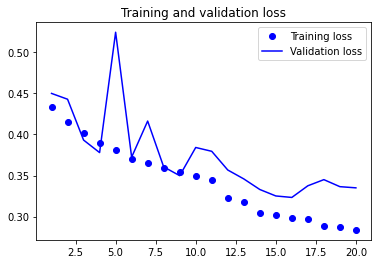

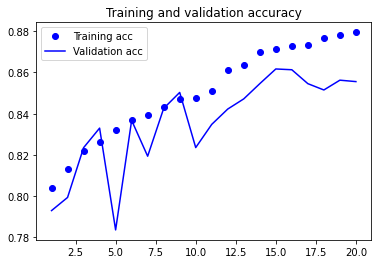

<Figure size 432x288 with 0 Axes>

In [81]:
# display the loss and accuracy curves
# https://www.kaggle.com/homayoonkhadivi/medical-diagnosis-histopathologic-cancer-cnn

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

You can see from the plots of training acc vs validation acc that we reached a global peak/valley around 15 epochs. At this point the training a validation accuracy begin to diverge (overfitting). Our model will keep the weights that achieved the highest validation accuracy.

# Setting Up Our Test Data And Directories for Model Prediction


In [ ]:
#Testing procedure taken from https://www.kaggle.com/homayoonkhadivi/medical-diagnosis-histopathologic-cancer-cnn

# Transfer the test images into image_dir
test_dir = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)
# check that the directory we created exists
os.listdir('test_dir')

In [45]:
test_list = os.listdir('../content/test')

for image in test_list:
    
    fname = image
    
    # source path to image
    src = os.path.join('../content/test', fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
# check that the images are now in the test_images
# Should now be 57458 images in the test_images folder

len(os.listdir('test_dir/test_images'))
test_path ='test_dir'


# Here we change the path to point to the test_images folder.

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [46]:
num_test_images = 57458



predictions = model.predict_generator(test_gen, steps=num_test_images, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


57458/57458 [==============================] - 169s 3ms/step


In [47]:
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,2.098383e-04,0.999790
1,9.194753e-04,0.999081
2,1.938681e-02,0.980613
3,1.370236e-09,1.000000
4,9.892341e-01,0.010766


In [48]:
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names
0,2.098383e-04,0.999790,test_images/00006537328c33e284c973d7b39d340809...
1,9.194753e-04,0.999081,test_images/0000ec92553fda4ce39889f9226ace43ca...
2,1.938681e-02,0.980613,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...
3,1.370236e-09,1.000000,test_images/000253dfaa0be9d0d100283b22284ab2f6...
4,9.892341e-01,0.010766,test_images/000270442cc15af719583a8172c87cd2bd...


In [49]:
def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names,id
0,2.098383e-04,0.999790,test_images/00006537328c33e284c973d7b39d340809...,00006537328c33e284c973d7b39d340809f7271b
1,9.194753e-04,0.999081,test_images/0000ec92553fda4ce39889f9226ace43ca...,0000ec92553fda4ce39889f9226ace43cae3364e
2,1.938681e-02,0.980613,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,1.370236e-09,1.000000,test_images/000253dfaa0be9d0d100283b22284ab2f6...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,9.892341e-01,0.010766,test_images/000270442cc15af719583a8172c87cd2bd...,000270442cc15af719583a8172c87cd2bd9c7746


In [50]:
y_pred = df_preds['has_tumor_tissue']

# get the id column
image_id = df_preds['id']

In [51]:
submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')

submission.to_csv('patch_preds.csv', columns=['label']) 
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.999790
0000ec92553fda4ce39889f9226ace43cae3364e,0.999081
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.980613
000253dfaa0be9d0d100283b22284ab2f6b643f6,1.000000
000270442cc15af719583a8172c87cd2bd9c7746,0.010766


In [ ]:
submission.to_csv("submission.csv", index = False, header = True) #submission 

# Conclusion
Overall this lab was a great learning experience. It made me feel very humble about the extent of my ML knowledge, and left me excited to learn more and keep experimenting. My first challenge was just to get the data into Colab and run a tf model. Once I figured that out, the challenge was figuring out what model to use as a starting point, given that there are many out there and the keras guide does not recommend starting from scratch. Once I chose a baseline model, I had to choose what to tweak, train/validation split, additional layers, learning rate, optimizers. In the end I settled on the ADAM optimizer and used a feature in Keras that can auto adjust the learning rate. My final accuracy was good at around 91% when I submitted to Kaggle. In the future I would like to get better at doing all of this from scratch without relying so heavily on tutorials. I also want to dive back into the theory and understand better why my final model was better than, for example, the model in the Keras image classification tutorial that is similar to resnet, or why my model is better than an ImageNet pretrained model. 

#### Sources:
* Intro to AI Lectures - CU Boulder 3202
* https://keras.io/api/layers/convolution_layers/convolution2d/
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/Cropping2D
* https://www.kaggle.com/homayoonkhadivi/medical-diagnosis-histopathologic-cancer-cnn
* https://www.kaggle.com/frlemarchand/transfer-learning-for-cancer-detection-keras
* https://towardsdatascience.com/data-preparation-guide-for-detecting-histopathologic-cancer-detection-7b96d6a12004
* https://keras.io/examples/vision/image_classification_from_scratch/#build-a-model

